In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

In this notebook, we calculate the mean average precision for the task of retrieving gene-compound pairs against random pairs. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. All the target annotations of the compounds are used in this analysis.
3. Negcon and empty wells are removed from the dataframe.
4. Average precision (AP) is computed for each chemical perturbation. Mean average precision (mAP) is computed for each perturbation.
5. The AP of a random classifier is subtracted from each perturbation’s AP.
6. Table of AP values is printed and bar plot of AP is plotted.

In [2]:
precision_df = pd.DataFrame()
batch = "2020_11_04_CPJUMP1"
all_percent_perturbation_df = pd.DataFrame()

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)
        modality_1_consensus_df = utils.consensus(modality_1_df, "Metadata_broad_sample")

        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
            .assign(Metadata_gene=lambda x: x.Metadata_target_list.str.split('|'))
            .assign(Metadata_gene_list=lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_gene')
            .reset_index(drop=True)
        )

        both_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in both_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = both_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')
                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_gene_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_broad_sample")

                modality_2_genes = list(np.unique(list(modality_2_consensus_df.Metadata_gene)))
                modality_1_consensus_filtered_df = modality_1_consensus_df.query('Metadata_gene==@modality_2_genes').reset_index(drop=True)

                score = utils.PrecisionScores(modality_1_consensus_filtered_df, modality_2_consensus_df, "Metadata_gene", anti_correlation=True)

                precision_df = precision_df.append({'Description':f'{modality_1_perturbation}_{modality_1_timepoint} vs. {modality_2_perturbation}_{modality_2_timepoint}',
                                                    'Modality1': f'{modality_1_perturbation}_{modality_1_timepoint:03}h',
                                                    'Modality2': f'{modality_2_perturbation}_{modality_2_timepoint:03}h',
                                                    'Cell': cell,
                                                    'mAP':f'{score.map:.3f}'}, ignore_index=True)


In [4]:
print(precision_df[['Description', 'mAP']].to_markdown(index=False))

| Description                |   mAP |
|:---------------------------|------:|
| compound_24 vs. crispr_144 | 0.028 |
| compound_24 vs. crispr_96  | 0.027 |
| compound_24 vs. orf_96     | 0.032 |
| compound_24 vs. orf_48     | 0.038 |
| compound_48 vs. crispr_144 | 0.032 |
| compound_48 vs. crispr_96  | 0.032 |
| compound_48 vs. orf_96     | 0.03  |
| compound_48 vs. orf_48     | 0.032 |
| compound_24 vs. crispr_144 | 0.033 |
| compound_24 vs. crispr_96  | 0.027 |
| compound_24 vs. orf_48     | 0.039 |
| compound_24 vs. orf_96     | 0.044 |
| compound_48 vs. crispr_144 | 0.032 |
| compound_48 vs. crispr_96  | 0.024 |
| compound_48 vs. orf_48     | 0.051 |
| compound_48 vs. orf_96     | 0.041 |


In [5]:
precision_df['mAP'] = precision_df['mAP'].astype(float)

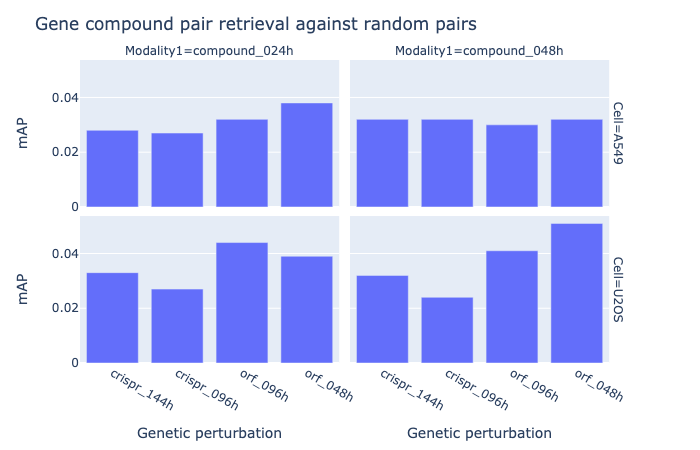

In [6]:
fig = px.bar(precision_df,
             x='Modality2',
             y='mAP',
             facet_col='Modality1',
             facet_row='Cell')
fig.update_layout(title='Gene compound pair retrieval against random pairs',
                  xaxis1=dict(title='Genetic perturbation'),
                  xaxis2=dict(title='Genetic perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/2.mAP_matching.png', width=640, height=480, scale=2)